# Create plots for article series "inntaksmodeller"

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import collections.abc
import math
import operator
import time
import pandas as pd
import os
from ortools.graph import pywrapgraph

from scipy.special import comb
from functools import reduce
import operator
from math import log10

In [2]:
save_dir = r"../figures"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
FIGSIZE = (6, 3)
COLORS = list(plt.rcParams['axes.prop_cycle'].by_key()['color'])

# Geography

In [3]:
def generate_problem(num_schools, num_students, seed=41, multiplier=50):
    """Generate a geographical problem."""
    
    np.random.seed(seed)
    school_capacities = np.ones(num_schools) * (num_students / num_schools)

    # Draw locations
    school_locations = np.random.randn(num_schools, 2)
    student_locations = np.random.randn(num_students, 2)

    # Create distance matrix
    distances = np.empty((num_students, num_schools))
    for i in range(num_students):
        for j in range(num_schools):
            distances[i][j] = multiplier * np.linalg.norm(school_locations[j, :] - student_locations[i, :])
            
    return distances, school_capacities,school_locations, student_locations


def solve_problem(num_schools, num_students, distances, school_capacities,  p=1):
    """Solve the min-cost problem."""
    
    min_cost_flow = pywrapgraph.SimpleMinCostFlow()

    node_names = list(range(1 + num_schools + num_students))

    # Add arcs from source to students
    for i in range(num_students):
        min_cost_flow.AddArcWithCapacityAndUnitCost(0, 1+i, 1, 0)

    # Add arcs from students to schools
    for i in range(num_students):
        for j in range(num_schools):
            dist = int(round(distances[i][j]**p))
            min_cost_flow.AddArcWithCapacityAndUnitCost(1+i, 1+num_students+j, 1, dist)

    # Add arcs from schools to target
    for j in range(num_schools):
        min_cost_flow.AddArcWithCapacityAndUnitCost(1+num_students+j, 
                                                    1+num_students+num_schools, 
                                                    int(school_capacities[j]), 0)

    min_cost_flow.SetNodeSupply(0, num_students)
    min_cost_flow.SetNodeSupply(1+num_students+num_schools, -num_students)
    
    
    ####################
    
    source = 0
    sink = 1+num_students+num_schools

    distances_solution = []
    chosen_schools = [None for i in range(num_students)]

    start_time = time.time()
    result = min_cost_flow.Solve()
    solve_time = time.time() - start_time
    
    assert result == min_cost_flow.OPTIMAL
    #print('Total cost = ', min_cost_flow.OptimalCost())
    for arc in range(min_cost_flow.NumArcs()):
        # Can ignore arcs leading out of source or into sink.
        if min_cost_flow.Tail(arc)!=source and min_cost_flow.Head(arc)!=sink:

            # Arcs in the solution have a flow value of 1. Their start and end nodes
            # give an assignment of worker to task.
            if min_cost_flow.Flow(arc) > 0:
                i = min_cost_flow.Tail(arc) - 1
                j = min_cost_flow.Head(arc) - num_students - 1
                distances_solution.append(distances[i][j])
                chosen_schools[i] = j
                
    return distances_solution, chosen_schools, solve_time 

## Create a plot where p=1 and p=2 are different

In [4]:
# Find a good seed where students are assigned differently

num_schools = 3
num_students = 90
multiplier = 1000

max_diff = 0
best_seed = 0

for seed in range(50):
    distances, school_capacities, _, _ = generate_problem(num_schools, num_students, 
                                                          seed=seed,
                                                         multiplier=multiplier)

    _, chosen1, _ = solve_problem(num_schools, num_students, distances, school_capacities, p=1)
    _, chosen2, _ = solve_problem(num_schools, num_students, distances, school_capacities, p=2)

    diff = sum(1 if i != j else 0 for i,j in zip(chosen1, chosen2))
    
    if diff > max_diff:
        max_diff = diff
        best_seed = seed

In [5]:
problem_data = generate_problem(num_schools, num_students, seed=best_seed, multiplier=multiplier)
distances, school_capacities,school_locations, student_locations = problem_data

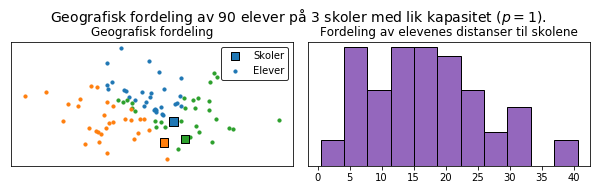

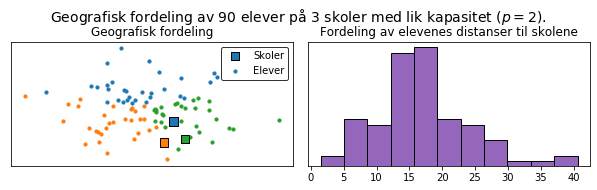

In [6]:
for p in [1, 2]:
    
    solved = solve_problem(num_schools, num_students, distances, school_capacities, p=p)
    distances_solution, chosen_schools, solve_time = solved

    plt.figure(figsize=(FIGSIZE[0]*1.4, FIGSIZE[1]*0.9))
    plt.suptitle(f"Geografisk fordeling av {num_students} elever på {num_schools} skoler med lik kapasitet ($p={p}$).", 
                 y=0.99, fontsize=14)

    plt.subplot(1, 2, 1)
    plt.title(f"Geografisk fordeling")

    plt.scatter(school_locations[:, 0], 
                school_locations[:, 1], marker="s", s=75, 
                zorder=10, color=COLORS[:num_schools],
               edgecolor='k', label="Skoler")

    labeled = False
    for i in range(num_students):
        color = COLORS[chosen_schools[i]]
        if not labeled and chosen_schools[i] == 0:
            plt.scatter(student_locations[i, 0], student_locations[i, 1], s=10,
                        zorder=5, color=color,
                       label="Elever")
            labeled=True
        else:
            plt.scatter(student_locations[i, 0], student_locations[i, 1], s=10,
                        zorder=5, color=color)

    plt.legend(edgecolor="k")
    plt.tight_layout()
    plt.xticks([], [])
    plt.yticks([], [])


    plt.subplot(1, 2, 2)
    plt.title(f"Fordeling av elevenes distanser til skolene")
    plt.hist(np.array(distances_solution)/100, bins=num_students//8, color=COLORS[num_schools+1], edgecolor="k")
    plt.yticks([], [])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    plt.savefig(os.path.join(save_dir, f"geographical_distribution_p_{str(int(p))}.png"), dpi=300)
    plt.show()

## Solution times on a large problem

In [7]:

# Solution times

# https://www.oslo.kommune.no/skole-og-utdanning/sokertall-videregaende-skole/
num_schools = 30
num_students = 233 * 30
print(num_schools, num_students)

solve_times = []
for seed in range(20):
    solve_times.append(0)
    continue
    distances, school_capacities, _, _ = generate_problem(num_schools, num_students, seed=seed)
    _, chosen1, solve_time = solve_problem(num_schools, num_students, distances, school_capacities, p=1)
    
    solve_times.append(solve_time)

# Result of 20 runs:
# (0.11042320728302002, 0.11192597150802612)
np.median(solve_times), np.mean(solve_times)

30 6990


(0.0, 0.0)

In [8]:
num_schools = 30
num_students = 233 * 30

def num_solutions(num_schools, num_students):
    students_per_class = num_students // num_schools
    assert students_per_class * num_schools == num_students
    combinations = [comb(num_students - i*students_per_class, students_per_class, exact=True)
for i in range(num_schools)]
    return log10(reduce(operator.mul, combinations))


num_solutions(num_schools, num_students)

10279.911207540123

## Pretty cover figure on medium-sized problem

In [9]:
num_schools = 5
num_students = 500
multiplier = 100

problem_data = generate_problem(num_schools, num_students, seed=7, multiplier=multiplier)
distances, school_capacities,school_locations, student_locations = problem_data

solved = solve_problem(num_schools, num_students, distances, school_capacities, p=2)
distances_solution, chosen_schools, solve_time = solved

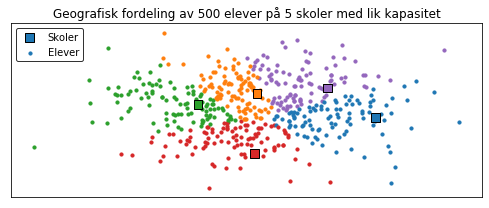

In [10]:
plt.figure(figsize=(FIGSIZE[0]*1.15, FIGSIZE[1]))
plt.title(f"Geografisk fordeling av {num_students} elever på {num_schools} skoler med lik kapasitet")

plt.scatter(school_locations[:, 0], 
            school_locations[:, 1], marker="s", s=75, 
            zorder=10, color=COLORS[:num_schools],
           edgecolor='k', label="Skoler")

labeled = False
for i in range(num_students):
    color = COLORS[chosen_schools[i]]
    if not labeled and chosen_schools[i] == 0:
        plt.scatter(student_locations[i, 0], student_locations[i, 1], s=10,
                    zorder=5, color=color,
                   label="Elever")
        labeled=True
    else:
        plt.scatter(student_locations[i, 0], student_locations[i, 1], s=10,
                    zorder=5, color=color)

plt.legend(edgecolor="k")
plt.tight_layout()
plt.xticks([], [])
plt.yticks([], [])
plt.tight_layout()
plt.savefig(os.path.join(save_dir, f"geographical_distribution_large.png"), dpi=300)
plt.show()

# Grades

In [11]:
from scipy.stats import rankdata

def rank_students(grades):
    percentiles = rankdata(grades, method='dense')
    percentiles = percentiles - np.min(percentiles)
    ans = percentiles / percentiles[-1]
    assert np.min(ans) == 0
    assert np.max(ans) == 1
    assert np.all(ans >= 0)
    assert np.all(ans <= 1)
    return ans

def generate_grade_averages(num_students, num_subjects, round_to=1, seed=2):
    np.random.seed(seed)
    grades = np.arange(1, 7)
    grade_probs = np.array([0.05, 0.15, 0.2, 0.3, 0.2, 0.1])

    # Clip a normal distribution
    grad_avgs = np.random.randn(num_students * 10) * 2.4 + 4
    grad_avgs = grad_avgs[(grad_avgs <= 6) & (grad_avgs >= 1.8)]
    grad_avgs = np.round(grad_avgs[:num_students], round_to)
    grad_avgs = np.sort(grad_avgs)
    return grad_avgs

## Show current transformation

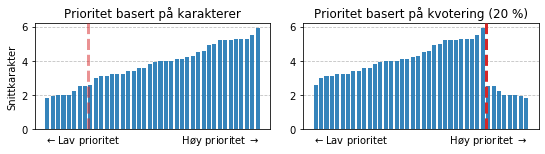

In [12]:
num_students = 40
num_subjects = 20
grad_avgs = generate_grade_averages(num_students, num_subjects)

percentage = 0.2
i = int(len(grad_avgs) * percentage)
# =============================================================================
plt.figure(figsize=(FIGSIZE[0]*1.3, FIGSIZE[1]*0.75))
plt.subplot(1, 2, 1)
plt.title(f"Prioritet basert på karakterer")

plt.bar(np.arange(num_students), grad_avgs, alpha=0.9, zorder=10, width=0.75)
plt.xticks([], [])
plt.grid(True, ls="--", zorder=5, alpha=0.8)
plt.xlabel(r"$\leftarrow$Lav prioritet" + r" "*20 + r"Høy prioritet $\rightarrow$")
plt.axvline(x=i-0.5, color=COLORS[3], ls="--", zorder=15, linewidth=3, alpha=0.5)
plt.ylabel(r"Snittkarakter")

# =============================================================================
plt.subplot(1, 2, 2)
plt.title(f"Prioritet basert på kvotering ({int(percentage * 100)} %)")

transformed = np.hstack((grad_avgs[i:], grad_avgs[:i][::-1]))

plt.bar(np.arange(num_students), transformed, alpha=0.9, zorder=10, width=0.75)
plt.xticks([], [])
plt.grid(True, ls="--", zorder=5, alpha=0.8)
plt.xlabel(r"$\leftarrow$Lav prioritet" + r" "*20 + r"Høy prioritet $\rightarrow$")
plt.axvline(x=num_students-i-0.5, color=COLORS[3], ls="--", zorder=15, linewidth=3)

plt.tight_layout()
plt.savefig(os.path.join(save_dir, "grade_priority_proposition.png"), dpi=300)
plt.show()

## Explain new transformation

[0.         0.06666667 0.13333333 0.2        0.26666667 0.33333333
 0.4        0.46666667 0.53333333 0.53333333 0.6        0.6
 0.66666667 0.73333333 0.73333333 0.8        0.86666667 0.93333333
 1.         1.        ]


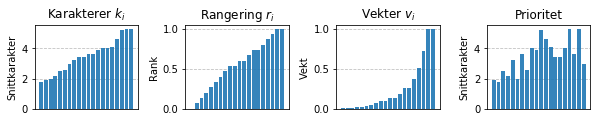

In [13]:
num_students = 20
num_subjects = 20
grad_avgs = generate_grade_averages(num_students, num_subjects)

# =============================================================================
plt.figure(figsize=(FIGSIZE[0]*1.4, FIGSIZE[1]*0.6))

plt.subplot(1, 4, 1)
plt.title(f"Karakterer $k_i$")
plt.bar(np.arange(num_students), grad_avgs, alpha=0.9, zorder=10)
plt.xticks([], [])
plt.grid(True, ls="--", zorder=5, alpha=0.8)
plt.ylabel(r"Snittkarakter")

# =============================================================================
plt.subplot(1, 4, 2)
plt.title(f"Rangering $r_i$")
percentiles = rank_students(grad_avgs)
print(percentiles)
plt.bar(np.arange(num_students), percentiles, alpha=0.9, zorder=10)
plt.xticks([], [])
plt.grid(True, ls="--", zorder=5, alpha=0.8)
plt.ylabel(r"Rank")

# =============================================================================
plt.subplot(1, 4, 3)
p = 5
plt.title(f"Vekter $v_i$")
percentiles_transformed = np.exp(percentiles * p) 
percentiles_transformed = percentiles_transformed / np.max(percentiles_transformed)
plt.bar(np.arange(num_students), percentiles_transformed, alpha=0.9, zorder=10)
plt.xticks([], [])
plt.grid(True, ls="--", zorder=5, alpha=0.8)
plt.ylabel(r"Vekt")

# =============================================================================
plt.subplot(1, 4, 4)
p = 5
plt.title(f"Prioritet")
weights = np.log(np.random.rand(num_students)) /(percentiles_transformed)
sorted_inds = np.argsort(weights)
plt.bar(np.arange(num_students), grad_avgs[sorted_inds], alpha=0.9, zorder=10)
plt.xticks([], [])
plt.grid(True, ls="--", zorder=5, alpha=0.8)
plt.ylabel(r"Snittkarakter")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "rank_transformation_explained.png"), dpi=300)
plt.show()


## Rank transformations

0.1717171717171717
0.0707070707070707
0.030303030303030304


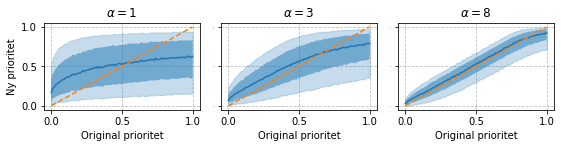

CPU times: user 653 ms, sys: 8.08 ms, total: 661 ms
Wall time: 657 ms


In [14]:
%%time

num_students = 100
num_subjects = 20

grad_avgs = generate_grade_averages(num_students, num_subjects, round_to=8)

exp1 = lambda x:np.exp(x) 
exp2 = lambda x:np.exp(x*3) 
exp3 = lambda x:np.exp(x*8) 
funcs = [exp1, exp2, exp3]
titles = [r"$\alpha=1$", 
          r"$\alpha=3$", 
          r"$\alpha=8$",]


simulations = 1_000_0
percentiles = rank_students(grad_avgs)

plt.figure(figsize=(FIGSIZE[0]*1.65*0.8, FIGSIZE[1]*0.8*0.9))

for i, (func, title) in enumerate(zip(funcs, titles)):

    percentiles_transformed = func(percentiles)
    # Linear transformation, does not affect weighting for sampling
    percentiles_transformed = percentiles_transformed / np.max(percentiles_transformed)

    # Dimension (simulations, students)
    runs = np.outer(np.ones(simulations), percentiles_transformed)
    weights = np.log(np.random.rand(*runs.shape)) / runs
    sorted_inds = np.argsort(weights, axis=1)

    # Trick to re-index multidimensional array from argsort
    # https://stackoverflow.com/questions/33140674/argsort-for-a-multidimensional-ndarray
    new_percentiles = np.outer(np.ones(simulations), percentiles)
    new_percentiles = new_percentiles[np.arange(np.shape(new_percentiles)[0])[:, np.newaxis], sorted_inds]
    
    assert np.all(new_percentiles.min(axis=1) == np.min(percentiles))
    assert np.all(new_percentiles.max(axis=1) == np.max(percentiles))


    ll, low, mid, high, hh = np.percentile(new_percentiles, q=[10, 25, 50, 75, 90], axis=0)

    print(mid[0])
    
    plt.subplot(1, len(titles), i+1)
    plt.title(title)
    plt.plot(percentiles, mid, zorder=50)
    plt.plot(percentiles, percentiles, zorder=99, color=COLORS[1], ls='--')
    plt.fill_between(percentiles, low, high, alpha=0.5, zorder=25)
    plt.fill_between(percentiles, ll, hh, alpha=0.25, color=COLORS[0], zorder=15)
    plt.grid(True, ls="--", zorder=5, alpha=0.8)
    plt.xlabel(r"Original prioritet")
    plt.xticks([0, 0.5, 1])
    plt.yticks([0, 0.5, 1])
    if i == 0:
        plt.ylabel(r"Ny prioritet")
    else:
        plt.yticks(fontsize=0)

plt.tight_layout()
plt.savefig(os.path.join(save_dir, "rank_transformations.png"), dpi=300)
plt.show()

## Rank transformations on data

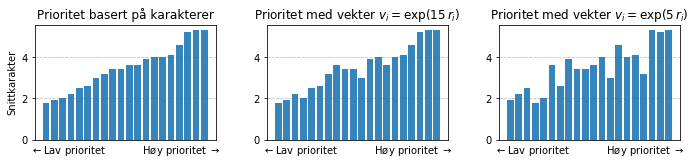

In [15]:
num_students = 20
num_subjects = 20

grad_avgs = generate_grade_averages(num_students, num_subjects)

# =============================================================================
plt.figure(figsize=(FIGSIZE[0]*1.65, FIGSIZE[1]*0.8))
#plt.suptitle(f"Fordeling av studenter", y=1.1)

plt.subplot(1, 3, 1)
plt.title(f"Prioritet basert på karakterer")

plt.bar(np.arange(num_students), grad_avgs, alpha=0.9, zorder=10)
plt.xticks([], [])
plt.grid(True, ls="--", zorder=5, alpha=0.8)
plt.xlabel(r"$\leftarrow$Lav prioritet" + r" "*12 + r"Høy prioritet $\rightarrow$")
plt.ylabel(r"Snittkarakter")

# =============================================================================
plt.subplot(1, 3, 2)
p = 15
plt.title(f"Prioritet med vekter $v_i = \exp ({p} \, r_i)$")
percentiles = rank_students(grad_avgs)
percentiles_transformed = np.exp(percentiles * p)
#plt.plot(percentiles_transformed)
weights = np.log(np.random.rand(num_students)) /(percentiles_transformed)
sorted_inds = np.argsort(weights)
plt.bar(np.arange(num_students), grad_avgs[sorted_inds], alpha=0.9, zorder=10)
plt.xticks([], [])
plt.grid(True, ls="--", zorder=5, alpha=0.8)
plt.xlabel(r"$\leftarrow$Lav prioritet" + r" "*12 + r"Høy prioritet $\rightarrow$")

# =============================================================================
plt.subplot(1, 3, 3)
p = 5
plt.title(f"Prioritet med vekter $v_i = \exp ({p} \, r_i)$")
percentiles = rank_students(grad_avgs)
percentiles_transformed = np.exp(percentiles * p) 
weights = np.log(np.random.rand(num_students)) /(percentiles_transformed)
sorted_inds = np.argsort(weights)
plt.bar(np.arange(num_students), grad_avgs[sorted_inds], alpha=0.9, zorder=10)
plt.xticks([], [])
plt.grid(True, ls="--", zorder=5, alpha=0.8)
plt.xlabel(r"$\leftarrow$Lav prioritet" + r" "*12 + r"Høy prioritet $\rightarrow$")

plt.tight_layout()
plt.savefig(os.path.join(save_dir, "rank_transformations_on_data.png"), dpi=300)
plt.show()


# Social inequality

## Simulated annealing on distance

In [16]:
# True answer
num_schools = 5
num_students = 500
multiplier = 1000
p = 2

problem_data = generate_problem(num_schools, num_students, seed=2, multiplier=multiplier)
distances, school_capacities,school_locations, student_locations = problem_data

solved = solve_problem(num_schools, num_students, distances, school_capacities, p=p)
distances_solution, chosen_schools, solve_time = solved


distances = distances / multiplier
distances_solution = [d / multiplier for d in distances_solution]

In [17]:
# Square the distances
distances = distances**p

In [18]:
sum(distances_solution)

630.580613257718

11.343362808227539


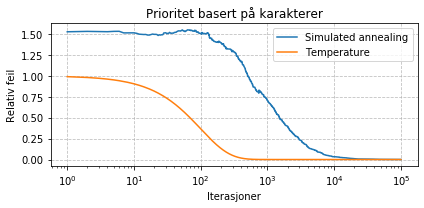

0.00045382207016474445


In [19]:
# Setup simulated annealing
x = np.zeros((num_students, num_schools), dtype=np.int)
assert x.shape == distances.shape

students_per_school = num_students // num_schools
assert students_per_school * num_schools == num_students

# Allocate randomly
chosen = set()
for j in range(num_schools):
    remaining = set(range(num_students)) - chosen
    students = np.random.choice(list(remaining), size=students_per_school, replace=False)
    x[students, j] = 1
    chosen.update(set(students))
    
assert np.all(np.sum(x, axis=0) == students_per_school)
assert np.all(np.sum(x, axis=1) == 1)
    
def get_school_inds(x):
    num_students, num_schools = x.shape
    return np.random.choice(list(range(num_schools)), size=2, replace=False)

def get_student_inds(x, j1, j2, student_inds):
    #assert j1 != j2
    num_students, num_schools = x.shape
    
    students_in_j1 = student_inds[x[:, j1] == 1]
    students_in_j2 = student_inds[x[:, j2] == 1]
    #assert set(students_in_j1).intersection(set(students_in_j2)) == set()
    i1, = np.random.choice(students_in_j1, size=1, replace=True)
    i2, = np.random.choice(students_in_j2, size=1, replace=True)
    return i1, i2

def evaluate(x, distances):
    num_students, num_schools = x.shape
    students_per_school = num_students // num_schools
    #assert students_per_school * num_schools == num_students
    #assert np.all(np.sum(x, axis=0) == students_per_school)
    return np.sum(distances * x)

best_cost_ever = float("inf")
best_solution_ever = None
cost = float("inf")

import time

st = time.time()

to_plot_iterations = []

iterations = list(range(1, 100000 + 1))
costs_to_plot = []
temperatures_to_plot = []

def temperature(iteration):
    return 0.99**iteration

student_inds = np.arange(num_students)
for iteration in iterations:
    
    j1, j2 = get_school_inds(x)
    i1, i2 = get_student_inds(x, j1, j2, student_inds)
    
    # Swap
    x[i1, j1], x[i1, j2] = x[i1, j2], x[i1, j1]
    x[i2, j1], x[i2, j2] = x[i2, j2], x[i2, j1]
    proposed_cost = evaluate(x, distances)
    temp = temperature(iteration)
    if (proposed_cost < cost) or (random.random() < temp):
        cost = proposed_cost
        #print(f"New best cost: {cost}")
    else:
        x[i1, j1], x[i1, j2] = x[i1, j2], x[i1, j1]
        x[i2, j1], x[i2, j2] = x[i2, j2], x[i2, j1]
        assert np.all(np.sum(x, axis=0) == students_per_school)
        
    if cost < best_cost_ever:
        best_solution_ever = x.copy()
        best_cost_ever = cost
        
    costs_to_plot.append(cost)
    temperatures_to_plot.append(temp)
    
    
print(time.time() - st)

# =============================================================================
plt.figure(figsize=(FIGSIZE[0], FIGSIZE[1]))
plt.title(f"Prioritet basert på karakterer")

min_cost_solution = sum(d**2 for d in distances_solution)
relative_error = (np.array(costs_to_plot) - min_cost_solution) / min_cost_solution

plt.semilogx(iterations, relative_error, label="Simulated annealing")
plt.semilogx(iterations, temperatures_to_plot, label="Temperature")

plt.grid(True, ls="--", zorder=5, alpha=0.8)
plt.xlabel(r"Iterasjoner")
plt.ylabel(r"Relativ feil")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "simulated_annealing_geography.png"), dpi=300)
plt.show()

print(relative_error[-1])

In [20]:
chosen_schools_annealed = np.sum(best_solution_ever * np.arange(best_solution_ever.shape[1]), axis=1)

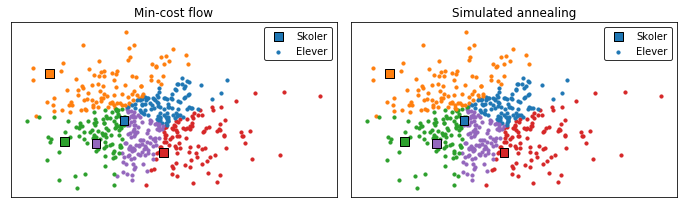

In [21]:
plt.figure(figsize=(FIGSIZE[0]*1.6, FIGSIZE[1]))
# =============================================================================
plt.subplot(1, 2, 1)
plt.title(f"Min-cost flow")

plt.scatter(school_locations[:, 0], school_locations[:, 1], marker="s", s=75, 
            zorder=10, color=COLORS[:num_schools], edgecolor='k', label="Skoler")

labeled = False
for i in range(num_students):
    color = COLORS[chosen_schools[i]]
    if not labeled and chosen_schools[i] == 0:
        plt.scatter(student_locations[i, 0], student_locations[i, 1], s=10,
                    zorder=5, color=color,
                   label="Elever")
        labeled=True
    else:
        plt.scatter(student_locations[i, 0], student_locations[i, 1], s=10,
                    zorder=5, color=color)

plt.legend(edgecolor="k")
plt.tight_layout()
plt.xticks([], [])
plt.yticks([], [])

# =============================================================================
plt.subplot(1, 2, 2)
plt.title(f"Simulated annealing")

plt.scatter(school_locations[:, 0], school_locations[:, 1], marker="s", s=75, 
            zorder=10, color=COLORS[:num_schools], edgecolor='k', label="Skoler")

labeled = False
for i in range(num_students):
    color = COLORS[chosen_schools_annealed[i]]
    if not labeled and chosen_schools_annealed[i] == 0:
        plt.scatter(student_locations[i, 0], student_locations[i, 1], s=10,
                    zorder=5, color=color,
                   label="Elever")
        labeled=True
    else:
        plt.scatter(student_locations[i, 0], student_locations[i, 1], s=10,
                    zorder=5, color=color)

plt.legend(edgecolor="k")
plt.tight_layout()
plt.xticks([], [])
plt.yticks([], [])

plt.tight_layout()
plt.savefig(os.path.join(save_dir, f"geographical_distribution_annealing.png"), dpi=300)
plt.show()

## Simulated annealing on: distance, social inequality, priorities

In [22]:
# True answer
num_schools = 5
num_students = 500

students_per_school = num_students // num_schools

def create_structured_problem(num_schools, num_students, seed=2):
    """Create a problem where everyone can get first prios,
    and the resulting allocation has equal grades in each school."""
    
    # Create grades
    grade_avgs = generate_grade_averages(students_per_school, num_subjects=20, round_to=2, seed=seed)
    grades = np.hstack(tuple((grade_avgs) for _ in range(num_schools)))
    assert len(grades) == num_students
    
    # Create priorities
    np.random.seed(seed)
    max_penalty = 5
    priorities = np.zeros((num_students, num_schools), dtype=np.int) + max_penalty
    for j in range(num_schools):
        rows = np.arange(students_per_school) + students_per_school * j
        priorities[rows, j] = 0

    for j in range(num_students):
        unwanted = np.arange(num_schools)[priorities[j, :] == max_penalty]
        u1, u2 = np.random.choice(unwanted, size=2, replace=False)
        priorities[j, u1] = 1
        priorities[j, u2] = 2
        
    return grades, priorities
    
    
    
def create_random_problem(num_schools, num_students, seed=2):
    """Create a problem that is random."""
    np.random.seed(seed)
    
    # Create grades
    grades = generate_grade_averages(num_students, num_subjects=20, round_to=2, seed=seed)
    grades = np.random.permutation(grades)
    assert len(grades) == num_students
    
    # Create priorities
    max_penalty = 5
    priorities = np.zeros((num_students, num_schools), dtype=np.int) + max_penalty
    prios = np.array([0, 1, 2] + [9] * (num_schools - 3))
    
    # Probabilities that schools are good
    p = np.arange(num_schools) + 1
    p = p / np.sum(p)
    
    for i in range(num_students):
        available_schools = np.arange(num_schools)
        
        chosen = np.log(np.random.random(num_schools)) / p
        inds = np.argsort(chosen)

        priorities[i, :] = prios[inds]
        
    return grades, priorities

In [23]:
def random_initial_solution(num_schools, num_students, seed):
    np.random.seed(seed)
    random.seed(seed)

    # Setup simulated annealing
    x = np.zeros((num_students, num_schools), dtype=np.int)

    students_per_school = num_students // num_schools
    assert students_per_school * num_schools == num_students

    # Allocate randomly
    chosen = set()
    for j in range(num_schools):
        remaining = set(range(num_students)) - chosen
        students = np.random.choice(list(remaining), size=students_per_school, replace=False)
        x[students, j] = 1
        chosen.update(set(students))

    assert np.all(np.sum(x, axis=0) == students_per_school)
    assert np.all(np.sum(x, axis=1) == 1)
    
    return x

In [24]:
def min_cost_flow_solution(num_schools, num_students, priorities):
    """Solve using min cost flow"""
    
    school_capacities = np.ones(num_schools) * (num_students//num_schools)
    solved = solve_problem(num_schools, num_students, priorities, school_capacities, p=1)
    distances_solution, chosen_schools, solve_time = solved
    x_mcf = np.zeros((num_students, num_schools), dtype=np.int)
    x_mcf[np.arange(num_students), chosen_schools] = 1

    return x_mcf

In [25]:
if True:
    grades, priorities = create_random_problem(num_schools, num_students, seed=2)
    PROBLEM_TYPE = "random"
else:
    grades, priorities = create_structured_problem(num_schools, num_students, seed=2)
    PROBLEM_TYPE = "structured"
    
print(PROBLEM_TYPE)

random


In [26]:
upper_bound_grades = np.std([6 for i in range(num_schools//2)] + [1 for i in range(num_schools//2)])
print(upper_bound_grades)

upper_bound_priorities = 9 * num_students
print(upper_bound_priorities)

2.5
4500


In [27]:
def random_lottery_solution(num_schools, num_students, priorities, seed):
    np.random.seed(seed)
    random.seed(seed)
    
    lottery_numbers = np.random.rand(num_students)
    student_order = np.arange(num_students)[np.argsort(lottery_numbers)]

    students_per_school = num_students // num_schools
    assert students_per_school * num_schools == num_students


    x = np.zeros((num_students, num_schools), dtype=np.int)

    for i in student_order:
        student_priorities = priorities[i, :]
        for priority, j in sorted(((p,j) for (j, p) in enumerate(student_priorities))):
            if x[:, j].sum() < students_per_school:
                x[i, j] = 1
                break

    assert np.all(np.sum(x, axis=0) == students_per_school)
    assert np.all(np.sum(x, axis=1) == 1)
    return x

In [28]:
def grades_first_solution(num_schools, num_students, priorities, grades, seed):
    np.random.seed(seed)
    random.seed(seed)
    
    tie_breaker = np.random.rand(num_students) / 10**6
    student_order = np.arange(num_students)[np.argsort(-grades + tie_breaker)]

    students_per_school = num_students // num_schools
    assert students_per_school * num_schools == num_students

    x = np.zeros((num_students, num_schools), dtype=np.int)

    for i in student_order:
        student_priorities = priorities[i, :]
        #print(i, student_priorities)
        for priority, j in sorted(((p,j) for (j, p) in enumerate(student_priorities))):
            #print(priority, j)
            if x[:, j].sum() < students_per_school:
                x[i, j] = 1
                #print(f"Placed student {i} at school {j}")
                #print(f"Priority {priorities[i, j]}. Places filled: {x[:, j].sum()}")
                break

    assert np.all(np.sum(x, axis=0) == students_per_school)
    assert np.all(np.sum(x, axis=1) == 1)
    return x

In [29]:
def evaluate(x, grades, priorities):
    num_students, num_schools = x.shape
    students_per_school = num_students // num_schools
    
    cost_priorities = np.sum(x * priorities) / num_students
    
    mean_grades = [grades[np.arange(num_students)[x[:, i] == 1]].mean() for i in range(num_schools)]
    cost_grades = np.std(mean_grades, ddof=0)
    return cost_priorities, cost_grades

In [30]:
num_solutions(num_schools, num_students)

344.23639026155564

In [31]:
x_lottery = random_lottery_solution(num_schools, num_students, priorities, seed=1)
evaluate(x_lottery, grades, priorities)

(0.984, 0.049044037354198294)

In [32]:
x_random = random_initial_solution(num_schools, num_students, seed=1)
evaluate(x_random, grades, priorities)

(4.528, 0.09568695626886646)

### Simulated annealing functions

In [33]:
def get_school_inds(x):
    num_students, num_schools = x.shape
    return np.random.choice(list(range(num_schools)), size=2, replace=False)

def get_student_inds(x, j1, j2, student_inds):
    num_students, num_schools = x.shape
    
    students_in_j1 = student_inds[x[:, j1] == 1]
    students_in_j2 = student_inds[x[:, j2] == 1]

    i1, = np.random.choice(students_in_j1, size=1, replace=True)
    i2, = np.random.choice(students_in_j2, size=1, replace=True)
    return i1, i2

def domination(solution, best_solution, mask):
    if not any(mask):
        return True
    
    solution = [s for (s, m) in zip(solution, mask) if m]
    best_solution = [s for (s, m) in zip(best_solution, mask) if m]

    not_worse = all(s <= b for (s, b) in zip(solution, best_solution))
    one_better = any(s < b for (s, b) in zip(solution, best_solution))
    return not_worse and one_better

def add_to_frontier(frontier, solution, solution_objective):
    """Add solution to frontier."""
    mask = [True] * len(solution_objective)
    
    dominated = [False for f in frontier]
    add_solution = True
    for i, (f_solution, f_objective) in enumerate(frontier):
        
        # If the solution under proposal dominates any existing, mark for removal
        if domination(solution_objective, f_objective, mask):
            dominated[i] = True
            
        # If the any existing solution dominates the one under proposal
        if domination(f_objective, solution_objective, mask):
            return frontier
        
    frontier = [f for (f, d) in zip(frontier, dominated) if not d]
    frontier.append((solution, solution_objective))
    return frontier
            
frontier = [(2, (2, 1))]
assert add_to_frontier(frontier, 3, (2, 0)) == [(3, (2, 0))]
assert add_to_frontier(frontier, 3, (2, 3)) == [(2, (2, 1))]
assert add_to_frontier(frontier, 3, (4, 0)) == [(2, (2, 1)), (3, (4, 0))]

In [34]:
def generate_itermediate(iterable):
    """Utility for step plotting."""
    iterable = sorted(iterable)
    for a, b in zip(iterable, iterable[1:]):
        yield a
        x1, y1 = a
        x2, y2 = b
        yield x2, y1
    yield b

In [35]:
x = random_initial_solution(num_schools, num_students, seed=0)

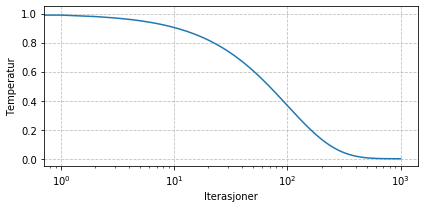

Frontier iteration 1
There are 1 solutions in the frontier
1 

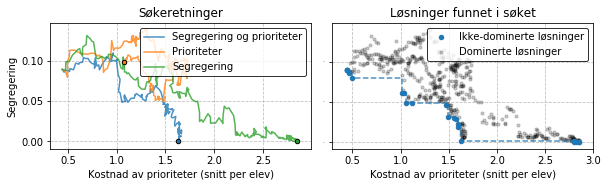

END; There are 45 solutions in the frontier


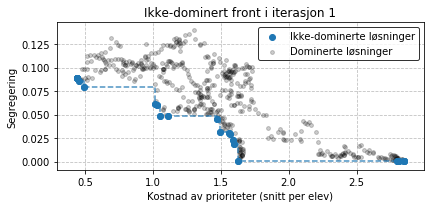

Frontier iteration 2
There are 45 solutions in the frontier
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 

In [ ]:
%%time

# Iinitial solution for the frontier
if PROBLEM_TYPE == "random":
    x = min_cost_flow_solution(num_schools, num_students, priorities)
else:
    x = random_initial_solution(num_schools, num_students, seed=0)
frontier = [(x.copy(), evaluate(x, grades, priorities))]

student_inds = np.arange(num_students)
masks = [[True, True], 
         [True, False], 
         [False, True]]

iterations = list(range(1000))
def temperature(iteration, start_value=1):
    return start_value*0.99**iteration

# =============================================================================
plt.figure(figsize=(FIGSIZE[0], FIGSIZE[1]))
tempz = list(temperature(i) for i in iterations)
plt.semilogx(iterations, tempz, label="Temperatures")
plt.grid(True, ls="--", zorder=5, alpha=0.8)
plt.xlabel(r"Iterasjoner")
plt.ylabel(r"Temperatur")
plt.tight_layout()
plt.show()

np.random.seed(123)
random.seed(123)

frontiers_per_iteration = []

for iteration_frontier in range(1, 34 + 1):
    print(f"Frontier iteration {iteration_frontier}")
    print(f"There are {len(frontier)} solutions in the frontier")
    
    paths = []

    # For every solution in the frontier
    for k, (x_frontier, objective_values) in enumerate(frontier):
        print(f"{k+1}", end=" ")

        # For every search diration
        for seed, mask in enumerate(masks):
            x = x_frontier.copy()
            best_cost_priorities, best_cost_grades = objective_values
            if iteration_frontier == 1:
                path = [(x, objective_values)]
            else:
                path = []
            for iteration in iterations:
                
                #np.random.seed(hash(str(iteration_frontier) + str(k) + str(seed)) % 10000)
                j1, j2 = get_school_inds(x)
                i1, i2 = get_student_inds(x, j1, j2, student_inds)

                # Swap
                x[i1, j1], x[i1, j2] = x[i1, j2], x[i1, j1]
                x[i2, j1], x[i2, j2] = x[i2, j2], x[i2, j1]
                cost_priorities, cost_grades = evaluate(x, grades, priorities) 

                dominates = domination((cost_priorities, cost_grades), 
                                       (best_cost_priorities, best_cost_grades),
                                        mask=mask)

                temp = temperature(iteration, start_value=1/iteration_frontier)
                if dominates or (random.random() < temp):
                    best_cost_priorities = cost_priorities
                    best_cost_grades = cost_grades
                    path.append((x.copy(), (best_cost_priorities, best_cost_grades)))
                else:
                    # Swap back
                    x[i1, j1], x[i1, j2] = x[i1, j2], x[i1, j1]
                    x[i2, j1], x[i2, j2] = x[i2, j2], x[i2, j1]
                    assert np.all(np.sum(x, axis=0) == students_per_school)
                    
            paths.append(path)
            
        # Create an educational plot
        if iteration_frontier == 1:
            
            # Add to frontier
            for path in paths:
                for x, objective in path:
                    frontier = add_to_frontier(frontier, x, objective)
            
            frontier_points = sorted([o for (s, o) in frontier])

            non_frontier = []
            for path in paths:
                for x, objective in path:
                    if objective not in frontier_points:
                        non_frontier.append(objective)
            
            plt.figure(figsize=(FIGSIZE[0]*1.6*0.9, FIGSIZE[1]*0.9))
            # =============================================================================
            plt.subplot(1, 2, 1)
            plt.title(f"Søkeretninger")
            labels = ["Segregering og prioriteter", 
                      "Prioriteter", 
                      "Segregering"]

            for i, (path, mask) in enumerate(zip(paths, masks)):
    
                plt.plot([i for (_, (i, j)) in path], [j for (_, (i, j)) in path], 
                         color=COLORS[i], label=labels[i], alpha=0.8, zorder=9)
                #plt.scatter([i for (_, (i, j)) in path[:1]], [j for (_, (i, j)) in path[:1]], 
                #            color=COLORS[i], zorder=9, edgecolor="k")
                plt.scatter([i for (_, (i, j)) in path[-1:]], [j for (_, (i, j)) in path[-1:]], 
                            color=COLORS[i], zorder=99, edgecolor="k", s=20)

            plt.legend(loc="best", edgecolor="k").set_zorder(99)
            plt.grid(True, ls="--", zorder=5, alpha=0.8)
            plt.xlabel("Kostnad av prioriteter (snitt per elev)")
            plt.ylabel("Segregering")

            # =============================================================================
            plt.subplot(1, 2, 2)
            plt.title(f"Løsninger funnet i søket")
            
            frontier_steps = list(generate_itermediate(frontier_points))
            plt.plot([i for (i, j) in frontier_steps], 
                     [j for (i, j) in frontier_steps], "--", alpha=0.8,
                     zorder=99)
            
            plt.scatter([i for (i, j) in frontier_points], 
                     [j for (i, j) in frontier_points], alpha=1, label="Ikke-dominerte løsninger",
                       zorder=99, s=20)

            plt.scatter([i for (i, j) in non_frontier], 
                        [j for (i, j) in non_frontier], alpha=0.2, color="k", s=10,
                       label="Dominerte løsninger", zorder=9) 

            plt.xlabel("Kostnad av prioriteter (snitt per elev)")
            plt.yticks(fontsize=0)
            plt.legend(loc="best", edgecolor="k").set_zorder(99)
            plt.grid(True, ls="--", zorder=5, alpha=0.8)
            
            plt.tight_layout()
            #plt.savefig(os.path.join(save_dir, f"annealing_directions_{PROBLEM_TYPE}_{num_schools}.png"), dpi=300)
            plt.show()
            
    # Add to frontier
    for path in paths:
        for x, objective in path:
            frontier = add_to_frontier(frontier, x, objective)
            
    print(f"END; There are {len(frontier)} solutions in the frontier")
    frontiers_per_iteration.append([j for (i, j) in frontier])
        

    # =================== CONVENIENCE PLOT ==================
    frontier_points = sorted([o for (s, o) in frontier])

    non_frontier = []
    for path in paths:
        for x, objective in path:
            if objective not in frontier_points:
                non_frontier.append(objective)

    plt.figure(figsize=(FIGSIZE[0]*1.0, FIGSIZE[1]))
    plt.title(f"Ikke-dominert front i iterasjon {iteration_frontier}")

    solutions_step = list(generate_itermediate(frontier_points))
    plt.plot([i for (i, j) in solutions_step], [j for (i, j) in solutions_step], "--",
              alpha=0.8, zorder=20)
    
    #plt.plot([i for (i, j) in frontier_points], [j for (i, j) in frontier_points], alpha=0.8)
    plt.scatter([i for (i, j) in frontier_points], [j for (i, j) in frontier_points], 
                alpha=1, zorder=20, label="Ikke-dominerte løsninger")
    plt.scatter([i for (i, j) in non_frontier], [j for (i, j) in non_frontier], 
                alpha=0.2, color="k", s=15, zorder=10, label="Dominerte løsninger")
    plt.xlabel("Kostnad av prioriteter (snitt per elev)")
    plt.ylabel("Segregering")
    plt.legend(loc="best", edgecolor="k").set_zorder(99)
    plt.grid(True, ls="--", zorder=5, alpha=0.8)
    plt.tight_layout()
    if iteration_frontier in [i**2 for i in range(10)]:
        pass
        #plt.savefig(os.path.join(save_dir, f"annealing_efficient_{PROBLEM_TYPE}_{num_schools}_iter_{iteration_frontier}.png"), dpi=300)
    plt.show()

In [ ]:
plt.figure(figsize=(FIGSIZE[0]*1.15, FIGSIZE[1]))
plt.title(f"Ikke-dominerte løsninger som funksjon av iterasjoner i PSMSS")
for i, solutions in enumerate(frontiers_per_iteration):
    if (i) in [2**i - 1 for i in range(15)]:
        solutions = sorted(solutions)
        solutions_step = list(generate_itermediate(solutions))
        plt.plot([i for (i, j) in solutions_step], [j for (i, j) in solutions_step], "--",
                  alpha=0.75, zorder=10+i)
        plt.scatter([i for (i, j) in solutions], [j for (i, j) in solutions],
                    label=f"Iterasjon {i+1}", alpha=0.75, zorder=10+i, s=15)
plt.xlabel("Kostnad av prioriteter (snitt per elev)")
plt.ylabel("Segregering")
plt.legend(loc="upper right", edgecolor="k")
plt.grid(True, ls="--", zorder=5, alpha=0.8)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, f"non_dom_set_{PROBLEM_TYPE}_{num_schools}.png"), dpi=300)
plt.show()

In [ ]:
frontier_points = sorted([o for (s, o) in frontier])

if PROBLEM_TYPE != "random":
    plt.figure(figsize=(FIGSIZE[0]*1.0 * 0.9, FIGSIZE[1]* 0.9))
    plt.title(f"Løsninger på et problem med kjent løsning")

    solutions_step = list(generate_itermediate(frontier_points))
    plt.plot([i for (i, j) in solutions_step], [j for (i, j) in solutions_step], "--",
             alpha=0.8, zorder=9)
    plt.scatter([i for (i, j) in frontier_points], [j for (i, j) in frontier_points], 
                alpha=1, zorder=9, label=f"Stokastisk optimering") 

    plt.scatter([0], [0], color=COLORS[1], label="Beste løsning", zorder=9)
    
    alpha = 0.5
    s = 15
    for i in range(100):
        x_random = random_initial_solution(num_schools, num_students, seed=i)
        x_1, x_2 = evaluate(x_random, grades, priorities)
        if i == 1:
            plt.scatter([x_1], [x_2], color=COLORS[2], label="Tilfeldige løsninger", zorder=9, alpha=alpha, s=s)
        else:
            plt.scatter([x_1], [x_2], color=COLORS[2], zorder=9, alpha=alpha, s=s)

    plt.xlabel("Kostnad av prioriteter (snitt per elev)")
    plt.ylabel("Segregering")
    plt.legend(loc="best", edgecolor="k")
    plt.grid(True, ls="--", zorder=5, alpha=0.8)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"comparison_{PROBLEM_TYPE}_{num_schools}.png"), dpi=300)
    plt.show()

In [ ]:
frontier_points = sorted([o for (s, o) in frontier])

if PROBLEM_TYPE == "random":
    plt.figure(figsize=(FIGSIZE[0]*1.0 * 0.9, FIGSIZE[1]* 0.9))
    plt.title(f"Sammenligning av løsninger ({num_students} elever, {num_schools} skoler)")
    
    alpha = 0.4
    s = 10
    num_sols = 1000

    solutions_step = list(generate_itermediate(frontier_points))
    #plt.plot([i for (i, j) in solutions_step], [j for (i, j) in solutions_step], "--",
    #         alpha=0.8, zorder=9)
    plt.scatter([i for (i, j) in frontier_points], [j for (i, j) in frontier_points], 
                alpha=1, zorder=9, label=r"PSMSS ($\alpha = 0$)", s=s) 

    
    for i in range(num_sols):
        x_lottery = random_lottery_solution(num_schools, num_students, priorities, seed=i)
        x_1, x_2 = evaluate(x_lottery, grades, priorities)
        if i == 1:
            plt.scatter([x_1], [x_2], color=COLORS[1], label="Loddtrekninger", zorder=9, alpha=alpha, s=s)
        else:
            plt.scatter([x_1], [x_2], color=COLORS[1], zorder=9, alpha=alpha, s=s)

    for i in range(num_sols):
        x_random = random_initial_solution(num_schools, num_students, seed=i)
        x_1, x_2 = evaluate(x_random, grades, priorities)
        if i == 1:
            plt.scatter([x_1], [x_2], color=COLORS[2], label="Tilfeldige fordelinger", zorder=9, alpha=alpha, s=s)
        else:
            plt.scatter([x_1], [x_2], color=COLORS[2], zorder=9, alpha=alpha, s=s)
            

    x_grades = grades_first_solution(num_schools, num_students, priorities, grades, seed=0)
    x_1, x_2 = evaluate(x_grades, grades, priorities)
    plt.scatter([x_1], [x_2], color=COLORS[3], label="Karakterbasert modell", zorder=9, alpha=1, s=s)
 

    plt.xlabel("Kostnad av prioriteter (snitt per elev)")
    plt.ylabel("Segregering")
    plt.legend(loc="best", edgecolor="k")
    plt.grid(True, ls="--", zorder=5, alpha=0.8)
    plt.tight_layout()
    #plt.savefig(os.path.join(save_dir, f"comparison_{PROBLEM_TYPE}_{num_schools}.png"), dpi=300)
    plt.show()

In [ ]:
frontier_points = sorted([o for (s, o) in frontier])

if PROBLEM_TYPE == "random":
    plt.figure(figsize=(FIGSIZE[0]*1.0 * 0.9, FIGSIZE[1]* 0.9))
    plt.title(f"Sammenligning av løsninger ({num_students} elever, {num_schools} skoler)")
    
    alpha = 0.6
    s = 10
    num_sols = 1000

    solutions_step = list(generate_itermediate(frontier_points))
    plt.plot([i for (i, j) in solutions_step], [j for (i, j) in solutions_step], "--",
             alpha=0.8, zorder=9)
    plt.scatter([i for (i, j) in frontier_points], [j for (i, j) in frontier_points], 
                alpha=1, zorder=9, label=r"PSMSS ($\alpha = 0$)", s=s*2) 

    
    for i in range(num_sols):
        x_lottery = random_lottery_solution(num_schools, num_students, priorities, seed=i)
        x_1, x_2 = evaluate(x_lottery, grades, priorities)
        if x_2 > 0.15 and x_1 > 1:
            x_lottery_final = x_lottery.copy()
        if i == 0:
            plt.scatter([x_1], [x_2], color=COLORS[1], label="Loddtrekninger", zorder=15, alpha=alpha, s=s)
        else:
            plt.scatter([x_1], [x_2], color=COLORS[1], zorder=15, alpha=alpha, s=s)
            

    plt.xlabel("Kostnad av prioriteter (snitt per elev)")
    plt.ylabel("Segregering")
    plt.legend(loc="best", edgecolor="k").set_zorder(99)
    plt.grid(True, ls="--", zorder=5, alpha=0.8)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"comparison_zoomed_{PROBLEM_TYPE}_{num_schools}.png"), dpi=300)
    plt.show()

In [ ]:
for (x_on_frontier, objectives) in sorted(frontier, key=lambda t:t[1]):
    x_1, x_2 = objectives
    if x_2 < 0.01:
        break

In [ ]:
plt.figure(figsize=(FIGSIZE[0]*1.7 * 0.9, FIGSIZE[1]* 0.9))

########################################################################
plt.subplot(1, 2, 1)
plt.title(f"Prioriteter innfridd, med snittkarakter per gruppe")

x_plt = np.arange(4)

labels = [r"PSMSS ($\alpha = 0$)", "Loddtrekning", "Karakterbasert modell"]
colors = [COLORS[0], COLORS[1], COLORS[3]]

for i, x_sol in enumerate([x_on_frontier, x_lottery_final, x_grades]):
    grade_distr = pd.Series(priorities[x_sol == 1]).value_counts()
    plt.bar(x_plt[:len(grade_distr)]-0.3+0.3*i, grade_distr.values, 
        zorder=10, width=0.3, label=labels[i], edgecolor="k", color=colors[i])
    for x, y_plt in enumerate(grade_distr.values):
        mask = np.any((priorities == grade_distr.index[x]) & (x_sol == 1), axis=1)
        mean_in_prio = grades[np.arange(num_students)[mask]].mean()
        plt.text(x=x-0.3+0.3*i - 0.125, y=y_plt+10, s=round(mean_in_prio, 1))

plt.xticks(x_plt, ["Førstevalg", "Andrevalg", "Tredjevalg", "Ingen valg"])
plt.ylabel("Antall elever")
plt.ylim([0, plt.ylim()[1] + 30])
plt.legend(loc="best", edgecolor="k").set_zorder(99)
plt.grid(True, ls="--", zorder=5, alpha=0.8)

########################################################################
plt.subplot(1, 2, 2)
plt.title(f"Snittkarakter per skole, med standardavvik")

# Get grades and plot them
grades_plt = [grades[np.arange(num_students)[x_on_frontier[:, i] == 1]] for i in range(num_schools)]
x_plt = np.arange(len(grades_plt))
plt.bar(x_plt-0.25, [m.mean() for m in grades_plt], 
        yerr=np.array([[m.std(), m.std()] for m in grades_plt]).T,
        zorder=10, width=0.25, edgecolor="k", color=COLORS[0])

grades_plt = [grades[np.arange(num_students)[x_lottery_final[:, i] == 1]] for i in range(num_schools)]
x_plt = np.arange(len(grades_plt))
plt.bar(x_plt, [m.mean() for m in grades_plt], 
        yerr=np.array([[m.std(), m.std()] for m in grades_plt]).T,
        zorder=10, width=0.25, edgecolor="k", color=COLORS[1])

grades_plt = [grades[np.arange(num_students)[x_grades[:, i] == 1]] for i in range(num_schools)]
x_plt = np.arange(len(grades_plt))
plt.bar(x_plt+0.25, [m.mean() for m in grades_plt], 
        yerr=np.array([[m.std(), m.std()] for m in grades_plt]).T,
        zorder=10, width=0.25, edgecolor="k", color=COLORS[3])

plt.xticks(x_plt, [f"Skole {i+1}" for i in x_plt])
plt.ylabel("Karakter")
plt.ylim([1, 6])
plt.grid(True, ls="--", zorder=5, alpha=0.8)

plt.tight_layout()
plt.savefig(os.path.join(save_dir, f"comparison_detailed_{PROBLEM_TYPE}_{num_schools}.png"), dpi=300)
plt.show()